In [531]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from itertools import groupby
from datetime import datetime, timedelta

Data Retrieval

In [532]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

global_data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers


Data Structures

In [533]:
class TreeNode:
    def __init__(self, name):
            self.name = name
            self.value = None
            self.children = []
            self.parent = None
    def add_child(self, child):
          child.parent = self
          self.children.append(child)
    def print_tree(self):
        prefix = '-'*self.get_level()
        print(prefix + self.name + ", " + str(self.value))
        if len(self.children) > 0:
            for child in self.children:
                child.print_tree()
    def get_level(self):
        if self.parent == None:
            return 0
        level = self.parent.get_level() + 1
        return level
    def get_child(self, name):
        for child in self.children:
            if child.name == name:
                return child

#takes in the database and the tree heirarchy
def build_user_tree(data):
     users = TreeNode("users")
     #iterates through each row of data, skipping over the headers, using the timestamp as a marker of a data entry
     i=1
     while(data[i][0] != ''):
        #compares each row of data if it matches any existing user, row  is the email
        entry = create_data_entry(data[i])
        if user_match(data[i],users):
             #adds this row to the tree of data
             user_match(data[i],users).get_child("data").add_child(entry)
        else:
             #create and append a user to an existing tree of users
             user = create_new_user(users)
             users.add_child(user)
             user.value = data[i][1]
             user.get_child("data").add_child(entry)
        i+=1
     return users
        
def user_match(row,users):
     if len(users.children) == 0:
        return 0
     for user in users.children:
        if row[1] == user.value:
            return user
     return 0
    
def create_data_entry(row):
    #if there is no timestamp, don't do it
    if row[0] != '':
        entry = TreeNode("entry")
        timestamp = TreeNode("timestamp")
        timestamp.value = (row[0])
        entry.add_child(timestamp)

        #make sure "workout" or '' do not show up. You can't check for type != string since all responses are str
        if row[2] != '' and row[2] != "workout":
            body_weight = TreeNode("body_weight")
            body_weight.value = (float(row[2]))
            entry.add_child(body_weight)
        else:
        #make sure that this is not an entry for a weight
        #if row[2] == "workout" and type(row[2]) != float and type(row[2]) != int:
            activity = TreeNode("activity")
            activity.value = row[3]
            entry.add_child(activity)

            # finish this later
            variants = TreeNode("variants")
            
            entry.add_child(variants)

            #if row[7] != '': # this shouldn't be necessary
            resistance_type = TreeNode("resistance_type")
            resistance_type.value = row[5]
            entry.add_child(resistance_type)

            if row[6] != '': # this shouldn't be necessary
                set_n = TreeNode("set_n")
                set_n.value = int(row[6])
                entry.add_child(set_n)

            if row[8] != '': # this shouldn't be necessary
                reps = TreeNode("reps")
                reps.value = int(row[8])
                entry.add_child(reps)

            if row[7] != '':
                weight = TreeNode("weight")
                weight.value = float(row[7])
                entry.add_child(weight)

            if row[9] != '':
                rpe = TreeNode("rpe")
                rpe.value = int(row[9])
                entry.add_child(rpe)
    return entry

def create_new_user(users):
    user = TreeNode("user"+str(len(users.children)))
    data = TreeNode("data")
    name = TreeNode("name")
    user.add_child(data)
    user.add_child(name)
    return user

def filter_helper(input, method, criteria, index):
    #print(criteria)
    #print(input)
    output = []
    if method == "string":
        for entry in input:
            for name in criteria:
                if type(entry[index]) != str:
                    continue
                #skips non-strings
                if entry[index] == name:
                    output.append(entry)
                else:
                    continue
    elif method == "numerical":
        #make error case when prompted with ranges that overlap
        for entry in input:
            for range in criteria:
                #print(entry)
                if type(entry[index]) == str:
                    entry[index] = float(entry[index])
                if entry[index] >= range[0] and entry[index] <= range[1]:
                    output.append(entry)
                else:
                    continue
    elif method == "variants":
        for entry in input:
            for lists in criteria:
                for name in lists:
                    if entry[index] == name:
                        output.append(entry)
                    else:
                        continue
                    
    else: 
        output = input
        print("error in filter function, no filter applied. criteria: " + criteria)
        

    return output

def filter_entries(input, criteria_type, criteria):
    #input is a table of data, 2D array
    #criteria type is what you are discriminating against
    #the criteria parameter itself is expected to be a list of ranges, so a list of a list being a 2D array as well.

    match criteria_type:
        case 'users':
            output = filter_helper(input, "string", criteria, 1)
        case 'time_ranges':
            output = filter_helper(input, "numerical", criteria, 0)
        #note that this uses the same row of data for bodyweight
        case 'workout':
            output = filter_helper(input, "string", criteria, 2)
        case 'body_weight_ranges':
            output = filter_helper(input, "numerical", criteria, 2)
        case 'activities':
            output = filter_helper(input, "string", criteria, 3)
        case 'variants':
            output = filter_helper(input, "variants", criteria, 4) # ideally you want to make another method for this filter
        case 'resistance_types':
            output = filter_helper(input, "string", criteria, 5)
        case 'set_n_ranges':
            output = filter_helper(input, "numerical", criteria, index=6)
        case 'rep_ranges':
            output = filter_helper(input, "numerical", criteria, 8)
        case 'weight_ranges':
            output = filter_helper(input, "numerical", criteria, 7)
        case _:
            print("no filter criteria recognized!")

    return output


if __name__ == '__main__':
    users = build_user_tree(global_data)
    users.print_tree()
    pass

users, None
-user0, sdimov77@gmail.com
--data, None
---entry, None
----timestamp, 2/26/2023 20:10:25
----activity, Bench
----variants, None
----resistance_type, barbell
----set_n, 1
----reps, 8
----weight, 155.0
----rpe, 7
---entry, None
----timestamp, 2/26/2023 20:12:49
----activity, Bench
----variants, None
----resistance_type, barbell
----set_n, 2
----reps, 8
----weight, 155.0
----rpe, 8
---entry, None
----timestamp, 2/26/2023 20:16:00
----activity, Bench
----variants, None
----resistance_type, barbell
----set_n, 3
----reps, 8
----weight, 155.0
----rpe, 9
---entry, None
----timestamp, 2/26/2023 20:19:36
----activity, Bench
----variants, None
----resistance_type, barbell
----set_n, 4
----reps, 8
----weight, 155.0
----rpe, 8
---entry, None
----timestamp, 2/26/2023 20:22:58
----activity, tricep pull
----variants, None
----resistance_type, cable
----set_n, 1
----reps, 3
----weight, 25.0
----rpe, 8
---entry, None
----timestamp, 2/26/2023 20:24:43
----activity, tricep pull
----variants, N

Data Analysis

In [534]:

def get_coord_pairs_from_user(user, criteria, unix_output):
    coord_pairs = []
    x = []
    currx = 0
    y = []
    for child in users.get_child(user).get_child("data").children:
        if child.get_child(criteria):
            if unix_output == True:
                currx = int(datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S').timestamp())
                x.append(currx)
            else:
                currx = datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S')
                x.append(currx)
            y.append(child.get_child(criteria).value)
            coord_pairs.append([currx, child.get_child("body_weight").value])
    return coord_pairs, x, y

def get_data_from_entries(data, criteria1, criteria2, data_type1, data_type2):
    #enumerate, for now its just indecies
    coord_pairs = []
    x = []
    y = []
    for entry in data:

        x.append(match_data_type(entry[criteria1], data_type1))
        y.append(match_data_type(entry[criteria2], data_type2))
        coord_pairs.append([match_data_type(entry[criteria1], data_type1), match_data_type(entry[criteria2], data_type2)])
              
    return coord_pairs, x, y

def match_data_type(input, data_type):
    match data_type:
        case "int":
            return int(input)
        case "float":
            return float(input)
        case "list":
            print("list type invoked! leaving data as is")
            return input
        case _:
            #leave as string
            return str(input)

def calculate_prediction_intervals(Set, y_model, dynamic, confidence_level, y_fit_original_size=[]):


    if len(y_fit_original_size) == 0:
        y_fit_original_size = y_model
    

    alpha = 1-confidence_level
    
    y = []
    x = []
    for pair in Set:
        x.append(pair[0])
        y.append(pair[1])

    if dynamic:
        #let's try to model the error as a set of data, and use that to create dynamic confidence intervals
        standard_errors = []
        for i in range(len(y)):

            standard_errors.append([x[i], std_err(y[i], y_model[i])])

        polynomial_degree = 4
        std_error_curve = fit_curve(standard_errors, polynomial_degree, linspace="default")

        prediction_intervals = []

        for i in range(len(y)):
            
            critical_value = stats.t.ppf(1 - alpha/2, df=len(y_model)-1)
            print("crit", critical_value)
            print("std_err", std_error_curve[i])
            print("y-model", y_model[i])
            lower_bound = y_model[i] - (critical_value * std_error_curve[i])
            upper_bound = y_model[i] + (critical_value * std_error_curve[i])
            prediction_intervals.append((lower_bound, upper_bound))
        return prediction_intervals

        #lower_bound = y_model + std_error_curve
        #upper_bound = y_model + std_error_curve
        #return lower_bound, upper_bound
    
    else:
        #use the mean of the entire errors to model the confidenc intervals statically
        # assume size of y_model = size of x


        mse = mean_squared_error(y, y_fit_original_size)

        # Calculate the standard error
        standard_error = np.sqrt(mse)
        # Assuming 95% confidence level (alpha = 0.05)
        
        
        prediction_intervals = []

        for i in range(len(y_model)):
        
            critical_value = stats.t.ppf(1 - alpha/2, df=len(y_model)-1)
            lower_bound = y_model[i] - (critical_value * standard_error)
            upper_bound = y_model[i] + (critical_value * standard_error)
            prediction_intervals.append((lower_bound, upper_bound))
        return prediction_intervals

# for individual points
def std_err(y1, y2):
    return np.sqrt(np.square((y1-y2)/2))


def fit_curve(Set, degree, linspace="default"):
    y = []
    x = []
    output = []

    for pair in Set:
        x.append(pair[0])
        y.append(pair[1])
    # Fit a polynomial of specified degree
    coeffs = np.polyfit(x, y, degree)
    if type(linspace) == str:
        linspace = x
    # Generate y values based on the fitted polynomial
    y_fit = np.polyval(coeffs, linspace)

    for i in range(len(linspace)):
        output.append([linspace[i], y_fit[i]])
    
    return output, linspace, y_fit

def pareto(data):
    x = []
    y = []
    z = []
    for element in data:
        x.append(element[0])
        y.append(element[1])
        z.append(element[0]*element[1])

    output = set(find_maxes(data, 1)).union(find_maxes(data, 0))
    output = find_maxes(output, 1)

    return output
#pareto-like max values for each bench
def unique_in_set(x, set):
    if len(set) > 0:
        for element in set:
            if x == element:
                if type(x) != type(element):
                    print("types do not match")
                return False
        return True
    else: 
        return True
    
    #probably should have used sets tbh
def make_unique(set, respect):
    #assumes 1d
    # need to unpack
    unpacked = []
    
    for element in set:
        unpacked.append(element[respect])
    
    unique_set = []
    for element in set:
        if unique_in_set(element[respect], unique_set):
            unique_set.append(element[respect])  
    return unique_set

def find_maxes(data, respect):
    # assumes 2d respect is which coordinate of the pair with respect to
    # set(x, y): 
    # maxes with respect to y would be finding unique values in y
    # then finding the max values of x for each y
    # given a rep range, find the largest weight for it
    maxes = set()
    #make the set of the other var unique
    unique_split_set = set()
    for element in data:
        unique_split_set.add(element[respect^1])
    
    # stopped using below because i discovered sets
    #unique_split = make_unique(data, respect ^ 1)
    for unique in unique_split_set:
        max = 0
        for element in data:
            if element[respect ^ 1] == unique:
                if element[respect] > max:
                    max = element[respect]
        if respect == 0:
            maxes.add((max, unique))
        else:
            maxes.add((unique, max))
    return maxes





def group_data_by_date2(data, date, grouping="daily"):
    # Convert date strings to datetime objects
    date_objects = [datetime.strptime(d, '%m/%d/%Y %H:%M:%S') for d in date]
    print(date_objects)

    # Combine data, date, and date objects into tuples
    combined_data = list(zip(date, date_objects, data))
    
    # Sort the combined data by date object
    sorted_data = sorted(combined_data, key=lambda x: x[1])

    # Group data by date
    grouped_data = {key: [item[2] for item in group] for key, group in groupby(sorted_data, key=lambda x: x[1])}

    # Convert grouped data to list of lists
    result = [[date.strftime('%m/%d/%Y %H:%M:%S'), values] for date, values in grouped_data.items()]
    return result


def group_data_by_timestamp(data, dates, grouping='day'):
    grouped_data = {}

    for i, date in enumerate(dates):
        date_obj = datetime.strptime(date, '%m/%d/%Y %H:%M:%S')

        if grouping == 'day':
            group_key = int((date_obj - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'week':
            # Get the first day of the week
            first_day_of_week = date_obj - timedelta(days=date_obj.weekday())
            group_key = int((first_day_of_week - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'month':
            # Get the first day of the month
            first_day_of_month = datetime(date_obj.year, date_obj.month, 1)
            group_key = int((first_day_of_month - datetime(1970, 1, 1)) / timedelta(seconds=1))
        elif grouping == 'year':
            # Get the first day of the year
            first_day_of_year = datetime(date_obj.year, 1, 1)
            group_key = int((first_day_of_year - datetime(1970, 1, 1)) / timedelta(seconds=1))
        else:
            raise ValueError("Invalid grouping option. Use 'day', 'week', 'month', or 'year'.")

        if group_key not in grouped_data:
            grouped_data[group_key] = []

        grouped_data[group_key].append(data[i])

        result = []
        for key, value in grouped_data.items():
            result.append([key, value])

    return result



Plotting

default case invoked! no change to unit/label
default case invoked! no change to unit/label


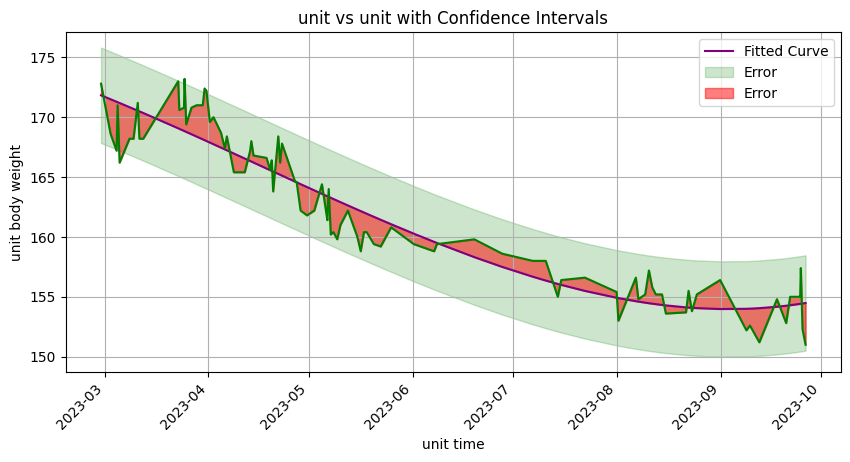

[[155.0, 8], [155.0, 8], [155.0, 8], [155.0, 8], [135.0, 5], [185.0, 6], [185.0, 4], [155.0, 7], [135.0, 1], [185.0, 1], [205.0, 1], [185.0, 4], [135.0, 12], [135.0, 8], [155.0, 10], [185.0, 4], [155.0, 8], [135.0, 9], [155.0, 8], [185.0, 7], [185.0, 3], [135.0, 8], [185.0, 4], [205.0, 2], [135.0, 8], [155.0, 8], [185.0, 3], [185.0, 5], [135.0, 10], [185.0, 5], [135.0, 8], [155.0, 8], [185.0, 3], [135.0, 8], [155.0, 8], [155.0, 10], [155.0, 5], [135.0, 8], [155.0, 8], [155.0, 8], [155.0, 5], [135.0, 4], [135.0, 8], [155.0, 8], [155.0, 6], [155.0, 7], [135.0, 8], [155.0, 8], [155.0, 8], [155.0, 8], [95.0, 8], [135.0, 8], [135.0, 8], [135.0, 8], [135.0, 7], [95.0, 8], [135.0, 8], [135.0, 8], [135.0, 8], [135.0, 8], [95.0, 7], [135.0, 8], [155.0, 8], [155.0, 6], [135.0, 10], [135.0, 8], [135.0, 8], [155.0, 8], [155.0, 5], [135.0, 8], [155.0, 8], [155.0, 7], [135.0, 9], [135.0, 8], [155.0, 8], [155.0, 8], [135.0, 8]]
[['2/26/2023 20:12:49', 'sdimov77@gmail.com', '', 'Bench', 'straight', 'b

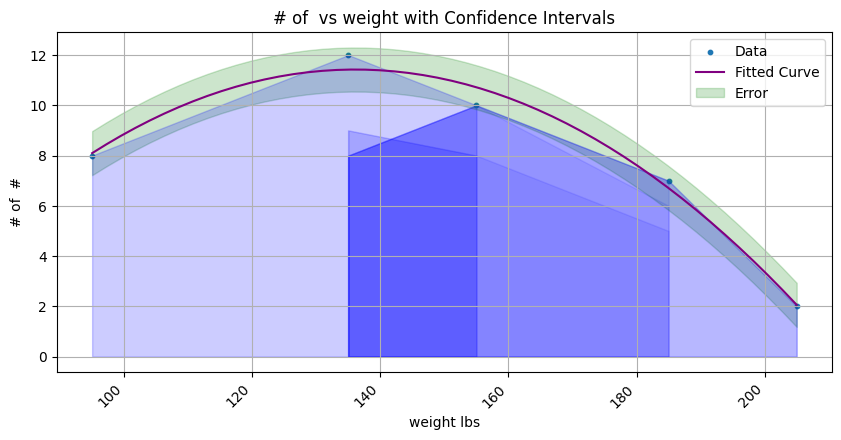

[[1677442225, [['2/26/2023 20:10:25', 'sdimov77@gmail.com', '', 'Bench', 'straight', 'barbell', 1.0, '155', '8', '7', '', '', '', '155', '6', '1240', '9670', '44983']]], [1677442369, [['2/26/2023 20:12:49', 'sdimov77@gmail.com', '', 'Bench', 'straight', 'barbell', 2.0, '155', '8', '8', '', '', '', '155', '4', '1240', '9670', '44983']]], [1677442560, [['2/26/2023 20:16:00', 'sdimov77@gmail.com', '', 'Bench', 'straight', 'barbell', 3.0, '155', '8', '9', '', '', '', '155', '6', '1240', '9670', '44983']]], [1677442776, [['2/26/2023 20:19:36', 'sdimov77@gmail.com', '', 'Bench', 'straight', 'barbell', 4.0, '155', '8', '8', '', '', '', '155', '51', '1240', '9670', '44983']]], [1677442978, [['2/26/2023 20:22:58', 'sdimov77@gmail.com', '', 'tricep pull', 'single arm', 'cable', '1', '25', '3', '8', '', '', '', '', '', '75', '9670', '44983']]], [1677443083, [['2/26/2023 20:24:43', 'sdimov77@gmail.com', '', 'tricep pull', 'single arm', 'cable', '2', '20', '6', '7', '', '', '', '', '', '120', '9670

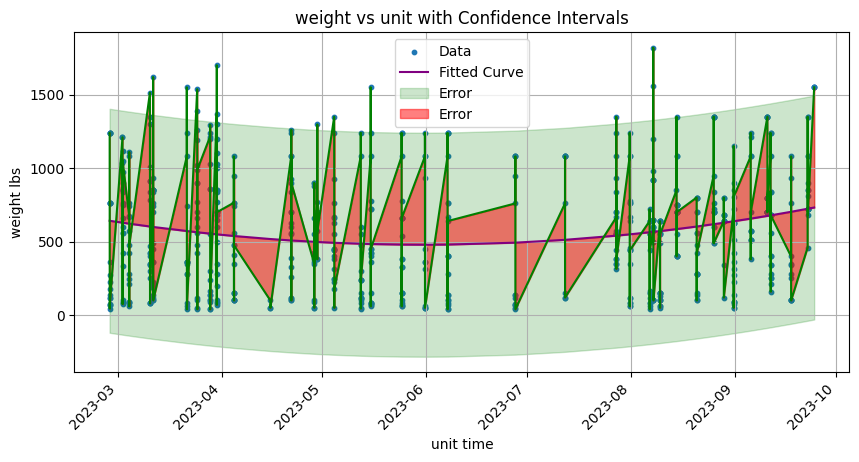

default case invoked! no change to unit/label
default case invoked! no change to unit/label


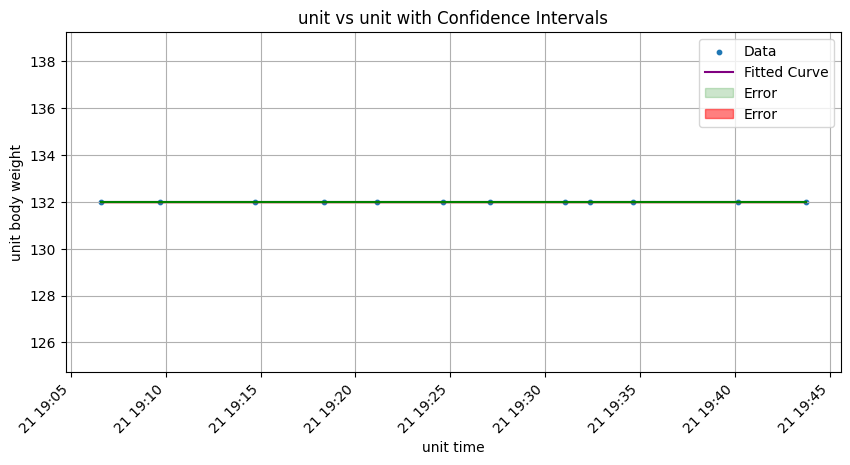

In [535]:


# Plotting
def get_graph_details(unit):
    if unit == "lbs":
        label = "weight"
    elif unit == "#":
        label = "# of "
    else: 
        label = "unit"
        print("default case invoked! no change to unit/label")
    return label

# given a set of data, and following attributes, plot them
def plot_desired_data(x_unit, y_unit, data_set, polynomial_degree, confidence_level, scatter=False, workout=False, all_sets=[]):
    # data_set is a 2D array, polynomial_degree is a natural number, confidence_level is a float between 0 < x < 1
    x_label = "x"
    y_label = "y"
    y = []
    x = []
    for pair in data_set:
        if x_unit == "time":
            # Convert to a datetime object

            #this assumes unix time-form
            if type(pair[0]) == int:
                dt_object = datetime.fromtimestamp(pair[0])
             #this assumes the string form
            #else:
            #    for pair[0] in x:
            #        x = int(datetime.strptime(pair[0], '%m/%d/%Y %H:%M:%S').timestamp())
            #        dt_object = datetime.fromtimestamp(pair[0])
            # Format the datetime object as a string
            
            #dt_object.strftime('%Y-%m-%d %H:%M:%S')
            #datetime.strptime(dt_object,'%Y-%m-%d %H:%M:%S')
                x.append(dt_object)
            
        else:
            x.append(pair[0])
        y.append(pair[1])
    
    x_label = get_graph_details(x_unit)
    y_label = get_graph_details(y_unit)
    
    #obtain curve of best fit
    if x_unit == "time":
        y_fit = fit_curve(data_set, polynomial_degree, linspace="default")[2]
        #print(y_fit)
    else:
        y_fit = fit_curve(data_set, polynomial_degree, linspace = np.linspace(np.min(x), np.max(x), 50))[2]
        print(y_fit)
    y_fit_original_size = fit_curve(data_set, polynomial_degree, linspace="default")[2]
    
    #print(data_set)
    #print(x, y)

    # Calculate prediction intervals
    upper = []
    lower = []
    upper_dynamic = []
    lower_dynamic = []

    for interval in calculate_prediction_intervals(data_set, y_fit, False, confidence_level, y_fit_original_size):
        lower.append(interval[0])
        upper.append(interval[1])

    # this is causing type errors, kinda useless anyway
    #for interval in calculate_prediction_intervals(data_set, y_fit, True, confidence_level):
    #    lower_dynamic.append(interval[0])
    #    upper_dynamic.append(interval[1])

    # Create the plot
    plt.subplots(figsize=(10, 5))

    #make step reps graph

    if len(all_sets) > 0:
       for set_n in all_sets:
            step_x = []
            step_y = []
            for pair in set_n:
                step_x.append(pair[0])
                step_y.append(pair[1])
                plt.fill_between(step_x, 0, step_y, color='blue', alpha=0.1)
    
    if scatter == True:
        plt.scatter(x, y, label='Data', s=10)

    if len(x) != len(y_fit):
        x1 = np.linspace(np.min(x), np.max(x), len(y_fit))
        plt.plot(x1, y_fit, color='purple', label='Fitted Curve')
        plt.fill_between(x1, lower, upper, color='green', alpha=0.2, label='Error')
        #plt.fill_between(x1, y, y_fit, color='red', alpha=0.5, label='Error')
    else:
        plt.plot(x, y_fit, color='purple', label='Fitted Curve')
        plt.fill_between(x, lower, upper, color='green', alpha=0.2, label='Error')
        plt.fill_between(x, y, y_fit, color='red', alpha=0.5, label='Error')
    #if workout == True:
    plt.xlabel(x_label + ' ' + x_unit)
    plt.gcf().autofmt_xdate()
    plt.ylabel(y_label + ' ' + y_unit)
    plt.title(y_label + ' vs ' + x_label + ' with Confidence Intervals')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    if workout == True:
        plt.fill_between(x, 0, y, color='blue', alpha=0.2, label='workout weight')
    else:
        plt.plot(x, y, 'g')
    #plt.fill_between(x, lower_dynamic, upper_dynamic, color='orange', alpha=0.5, label='Confidence Interval')
    plt.show()

data = get_coord_pairs_from_user("user0", "body_weight", True)[0]
plot_desired_data("time", "body weight", data, 3, .95, False)

steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

steve_data = filter_entries(steve_data, "activities", ["Bench"])

steve_data = filter_entries(steve_data, "variants", [["straight"]])

steve_data = filter_entries(steve_data, "resistance_types", ["barbell"])

data = get_data_from_entries(steve_data, 7, 8, "float", "int")[0]
print(data)
set_2 = filter_entries(steve_data, "set_n_ranges", [[2,2]])
print(set_2)
set_2 = get_data_from_entries(set_2, 7, 8, "float", "int")[0]
set_2 = pareto(set_2)
set_2 = sorted(set_2, key=lambda x: x[0])

set_3 = filter_entries(steve_data, "set_n_ranges", [[3,3]])
set_3 = get_data_from_entries(set_3, 7, 8, "float", "int")[0]
set_3 = pareto(set_3)
set_3 = sorted(set_3, key=lambda x: x[0])

set_4 = filter_entries(steve_data, "set_n_ranges", [[4,4]])
set_4 = get_data_from_entries(set_4, 7, 8, "float", "int")[0]
set_4 = pareto(set_4)
set_4 = sorted(set_4, key=lambda x: x[0])

all_sets=[set_2,set_3,set_4]

#all_sets = get_data_from_entries(all_sets, 7, 8, "float", "int")[0]
#all_sets = pareto(all_sets)

data = pareto(data)

data = sorted(data, key=lambda x: x[0])

#all_sets = []

#for i in range(3):

print(len(all_sets))
print("all_sets")
print(all_sets)

plot_desired_data("lbs", "#", data, 2, 0.95, True, all_sets=all_sets, workout=True)


# let's try to graph daily volume
steve_data = filter_entries(global_data[1:], "users", ["sdimov77@gmail.com"])

#make sure calisthenics have values for now
last_body_weight = 0
for entry in steve_data:
    if entry[2] != 'workout' and entry[2] != '':
        last_body_weight = entry[2]
    if entry[5] == "calisthenic":
        #print(entry)
        entry[7] = last_body_weight
        #print(entry)

steve_data = filter_entries(steve_data, "workout", ["workout",''])

dates = []
for entry in steve_data:
    dates.append(entry[0])

#int(datetime.strptime(entry[0], '%m/%d/%Y %H:%M:%S').timestamp())
    
data_by_date = group_data_by_timestamp(steve_data, dates, grouping="day")
#[[date,entries],[date2,entries]]
print(data_by_date)

daily_volume = []
for day in data_by_date:
    #print(day)
    volume = 0
    for entry in day[1]:
        #print(entry)
        # having issues with calisthenics since data doesn't have values for them
        volume += float(entry[7])*float(entry[8])
        
    daily_volume.append((day[0],volume))
print(daily_volume)

plot_desired_data("time", "lbs", daily_volume, 2, 0.95, True)



#plt.scatter(get_data_from_entries(steve_data, 7, 8)[1], get_data_from_entries(steve_data, 7, 8)[2])
#data = get_coord_pairs_from_user("user0", "activity", True)[0]
#plot_desired_data("weight", "bench", data, 2, 0.95)

#alex data, test for another user
data = get_coord_pairs_from_user("user1", "body_weight", True)[0]
plot_desired_data("time", "body weight", data, 2, 0.95, True)


In [536]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

tab1

,2023-02-26 20:10:24.513000,sdimov77@gmail.com,Unnamed: 2,Bench,straight,barbell,1,155,8,7,Unnamed: 10,Unnamed: 11,Unnamed: 12,155.1,6,1240,9670,44983
0,2023-02-26 20:12:48.526,sdimov77@gmail.com,NaN,Bench,straight,barbell,2.0,155.0,8.0,8.0,NaN,NaN,NaN,155.0,4.0,1240.0,9670.0,44983
1,2023-02-26 20:15:59.527,sdimov77@gmail.com,NaN,Bench,straight,barbell,3.0,155.0,8.0,9.0,NaN,NaN,NaN,155.0,6.0,1240.0,9670.0,44983
2,2023-02-26 20:19:36.136,sdimov77@gmail.com,NaN,Bench,straight,barbell,4.0,155.0,8.0,8.0,NaN,NaN,NaN,155.0,51.0,1240.0,9670.0,44983
3,2023-02-26 20:22:57.518,sdimov77@gmail.com,NaN,tricep pull,single arm,cable,1.0,25.0,3.0,8.0,NaN,NaN,NaN,NaN,NaN,75.0,9670.0,44983
4,2023-02-26 20:24:43.467,sdimov77@gmail.com,NaN,tricep pull,single arm,cable,2.0,20.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,120.0,9670.0,44983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
745,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
746,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
747,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
